In [1]:
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np

In [2]:
start = dt.datetime(2015,9,1)
end = dt.datetime(2020,9,1)
df = web.DataReader('DAL','yahoo',start,end)
df.head()

TypeError: string indices must be integers

Calculating moving averages of the stock data's closing prices to observe trends in the data. 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5437698

In [ ]:
import matplotlib.pyplot as plt
ma_day = [10,30,60]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    ma_df = df
    ma_df[column_name] = ma_df["Adj Close"].rolling(ma).mean()

plt.figure(figsize=(13,4))
plt.plot(df["Close"],label="Closing Price")
plt.plot(df["MA for 10 days"],label="10 Day Moving Average")
plt.plot(df["MA for 30 days"],label="30 Day Moving Average")
plt.plot(df["MA for 60 days"],label="60 Day Moving Average")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.title("Moving Averages")

Splitting data into training and test datasets. Only moving the closing price data to both datasets. In the paper below, a choice is made from the features high, low, date, open and close. Here I have chosen the closing prices.

In [3]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data = df.iloc[:train_size, 3:4].values
test_data = df.iloc[train_size:, 3:4].values

NameError: name 'df' is not defined

Paper below states that one of the steps of the data preprocessing is data transformation. Specifically the papaer suggests to normalize the data.
There are many different ways to normalize data. Paper below states different ways of normalazing stock data specifically, and the affects this has.
My choice of normalization is using a MinMaxScaler.

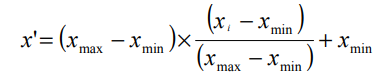

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

NameError: name 'train_data' is not defined

This function here is used to split datasets into x and y sets. Here I am using sequences to split to organise the data into x and y. The paper below did the same thing.
For example if you used a time step of 30. The input would be the closing prices of Days 1 to 30. And the output would be the closing price on Day 31. The next input would be the closing prices of Days 2 to 31. The output would be the closing price of Day 32. This process is carried for all of the data.

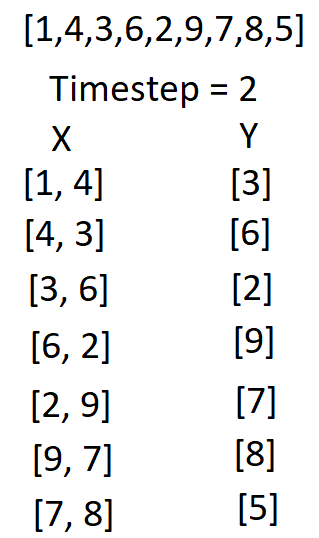

In [5]:
def organise_data(dataset,time_step):
    x_data = []
    y_data = []
    for i in range(0,len(dataset)-time_step):
        x_data.append(dataset[i:i+time_step])
        y_data.append(dataset[i+time_step])
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data,y_data

In [7]:
time_step = 100
x_train, y_train = organise_data(train_data,time_step)
x_test, y_test = organise_data(test_data,time_step)

NameError: name 'train_data' is not defined

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D

In [10]:
seq = 10
steps = 10
features = 1
cnn_x = x_train.reshape((x_train.shape[0],seq,steps,1))

In [11]:
cnn_model = Sequential()
cnn_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, steps, 1)))
cnn_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_model.add(TimeDistributed(Flatten()))
cnn_model.add(LSTM(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(loss="mean_squared_error",optimizer="adam")

In [23]:
cnn_model.fit(cnn_x, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0016
Epoch 2/50
29/29 [==============================] - 0s 15ms/step - loss: 0.0014
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 4/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 5/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 6/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 7/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0012
Epoch 8/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 9/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 10/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 11/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0012
Epoch 12/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 13/50
29/29 [==================

In [15]:
model = cnn_model

In [16]:
cnn_test = x_test.reshape(x_test.shape[0],seq,steps,features)

In [17]:
predicted_prices = model.predict(cnn_test)
#amount,nx,ny = predicted_prices.shape
#predicted_prices = predicted_prices.reshape(amount,nx*ny)
predicted_prices = scaler.inverse_transform(predicted_prices)
graph_predict = []
for i in range(len(predicted_prices)):
    graph_predict.append(predicted_prices[i][0])

In [18]:
actual_prices = scaler.inverse_transform(y_test)
graph_actual = []
for i in range(len(actual_prices)):
    graph_actual.append(actual_prices[i][0])

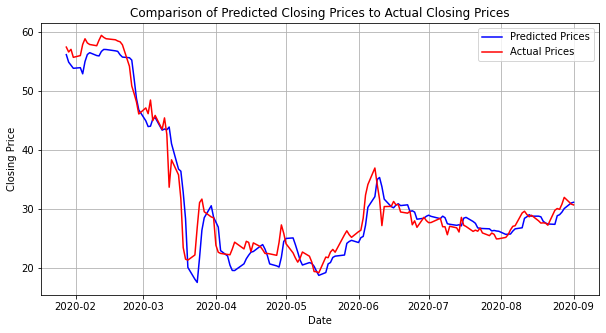

In [24]:
plt.figure(figsize=(10,5))
dates = df[train_size+time_step:].index
plt.plot(dates,graph_predict,color="blue",label="Predicted Prices")
plt.plot(dates,graph_actual,color="red",label="Actual Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Comparison of Predicted Closing Prices to Actual Closing Prices")
plt.grid()
plt.legend()
plt.show()

In [21]:
def normalize_metric(result, data):
    normalized = result / (max(data) - min(data))
    return normalized

In [25]:
import sklearn.metrics
import math
from sklearn import preprocessing

#Calculating RMSE
mse = sklearn.metrics.mean_squared_error(graph_actual, graph_predict)
rmse = math. sqrt(mse)
print("Root Mean Squared Error: ",normalize_metric(rmse, graph_actual))

#Calculate MAE
val_sum = 0
for i in range(len(graph_actual)):
    val_sum += abs(graph_actual[i]-graph_predict[i])
error = val_sum/len(graph_actual)
print("Mean Absolute Error: ",normalize_metric(error, graph_actual))

#Calcualting R Squared
correlation_matrix = np.corrcoef(graph_actual, graph_predict)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print("R Squared: ",r_squared)
#normalize_metric(r_squared, graph_actual)

Root Mean Squared Error:  0.06611134466557848
Mean Absolute Error:  0.04658823536258049
R Squared:  0.9484390030450933


In [87]:
import copy
def predict_next_days(dataset,time_step, time_period):
    #Getting last time_step days of data
    temp_start = len(dataset) - time_step
    x_input = dataset[temp_start:].reshape(1,-1)
    
    #Predicting prices of next time_period days
    temp_input = copy.deepcopy(x_input)
    prediction = []
    for i in range(time_period):
        if len(temp_input[0]) > time_step:
            start_index = len(temp_input[0]) - time_step
            temp_input.tolist()
            model_input = temp_input[0][start_index:]
            model_input = np.array([model_input])
            temp_input = np.array(temp_input)
        else:
            model_input = temp_input
        y_predict = model.predict(model_input, verbose = 0)
        y_predict = y_predict.reshape(y_predict.shape[0],y_predict.shape[1]*y_predict.shape[2])
        pred_price = scaler.inverse_transform(y_predict)
        prediction.append(pred_price[0][0])
        temp_input = np.append(temp_input, y_predict,axis=1)
    return prediction

In [50]:
import datetime
future_pred = predict_next_days(test_data,time_step,30)
plt.figure(figsize=(10,5))
plt.plot(dates,graph_actual,label="Test Data")
future_dates = []
for i in range(30):
    future_dates.append(dates[-1]+datetime.timedelta(i))
plt.plot(future_dates,future_pred,label="Future Prediction")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Predicting 30 Days into the Future")
plt.grid()
plt.legend()

IndexError: tuple index out of range

Building LSTM without Tensorflow: 
https://www.datacamp.com/community/tutorials/lstm-python-stock-market
Try and predict log return
Try and understand why loss function is higher than paper
Go to other paper, try and see how they do it different
To get first check different papers and compare
Try and predict more companies

Bidirectional LSTM Papers
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8355458
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9257950